In [4]:
import torchvision
from torch.utils import data as D
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage import data
from skimage import feature
from skimage import measure
from skimage import img_as_float
from skimage import color
import scipy
from scipy import ndimage

In [5]:
train_data = glob.glob("/data/facade_segmentation/images/png/original/img*.png")
mask_data = glob.glob("/data/facade_segmentation/images/png/original/lbl*.png")

In [6]:
train_data.sort()
mask_data.sort()

In [4]:
def resize(img, mask):
    img  = cv2.resize(img, (300, 300), interpolation = cv2.INTER_NEAREST)
    mask = cv2.resize(mask, (300, 300), interpolation = cv2.INTER_NEAREST)
    
    return img, mask

def get_ground_truth(img, mask, gt_mask, label, color):

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    mask = adjust_mask(mask, label)
    
    blur   = cv2.GaussianBlur(src = mask, 
    ksize  = (5, 5), 
    sigmaX = 1)
    (t, binary) = cv2.threshold(src = blur,
         thresh = 1, 
         maxval = 255, 
         type   = cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(image = binary, 
    mode = cv2.RETR_EXTERNAL,
    method = cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    coordinates_label_boxes = []
    unique_labels_per_img = np.array([0])
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        boxes.append([x, y, w, h])
        
    for box in boxes:
        top_left     = (box[0], box[1])
        top_right    = (box[0] + box[2], box[1])
        bottom_right = (box[0] + box[2], box[1] + box[3])
        bottom_left  = (box[0], box[1] + box[3])
        
        x_min, y_min, x_max, y_max = box[0], box[1], box[0] + box[2], box[1]+box[3]
        cv2.rectangle(img, top_left, bottom_right, color, 2)
        cv2.rectangle(gt_mask, top_left, bottom_right, color, 2)
        coordinates_label_boxes.append((x_min, y_min, x_max, y_max, label))
       
      
    return img, gt_mask, coordinates_label_boxes
        
        
        
def adjust_mask(mask, label):
    k = mask > label
    mask[k] = 0
    k = mask < label
    mask[k] = 0
    k = (mask == label)
    mask[k] = 255
    return mask
    

In [5]:
def create_filename(img_name):
    i = img_name.split("/")
    i = i[len(i)-1]
    i = i.split("_")
    filename = i[0] + "_resized_" + i[1]
    
    i = i[1].split(".")
    
    return filename, i[0]

In [7]:
for i in range(len(train_data)):
    img = cv2.imread(train_data[i])
    mask = cv2.imread(mask_data[i])
    
    img, mask = resize(img, mask)
    
    copy_img = img.copy()
#     path = "/data/ssd_ilija_data/original_images/"
#     name_img, number = create_filename(train_data[i])
#     path_filename = path + name_img
    
#     cv2.imwrite(path_filename, img)
    
    boxes_img = []
    labels_img = []
    
    gt_mask = np.zeros((300,300,3), np.uint8)
    gt, gt_mask, bboxes = get_ground_truth(img, mask, gt_mask, 1, (255, 255, 0))
    if(len(bboxes) > 0):
        boxes_img = boxes_img + bboxes
        labels_img.append(1)
    gt, gt_mask, bboxes = get_ground_truth(gt, mask, gt_mask, 2, (60, 180, 75))
    if(len(bboxes) > 0):
        boxes_img = boxes_img + bboxes
        labels_img.append(2)
    gt, gt_mask, bboxes = get_ground_truth(gt, mask, gt_mask, 3, (230, 25, 75))
    if(len(bboxes) > 0):
        boxes_img = boxes_img + bboxes
        labels_img.append(3)
    
    if(len(boxes_img) !=0):
        
#         img, mask = resize(img, mask)
        path = "/data/ssd_ilija_data/original_images/"
        name_img, number = create_filename(train_data[i])
        path_filename = path + name_img
    
        cv2.imwrite(path_filename, copy_img)
        
        path_gt = "/data/ssd_ilija_data/ground_truth/gt_with_bboxes/"
        filename_gt = "gt_" + number + ".png"

        path_gt_mask = "/data/ssd_ilija_data/ground_truth/mask_with_bboxes/"
        filename_gt_mask = "gt_mask_" + number + ".png"

        path_filename_gt_mask = path_gt_mask + filename_gt_mask
        cv2.imwrite(path_filename_gt_mask, gt_mask)

        path_filename_gt = path_gt + filename_gt
        cv2.imwrite(path_filename_gt, gt)

        path_label_bboxes = "/data/ssd_ilija_data/ground_truth/bboxes_labels/"
        bboxes_filename = "bboxes_"+ number 
        labels_filename = "labels_" + number

        path_bboxes_filename = path_label_bboxes + bboxes_filename
        path_labels_filename = path_label_bboxes + labels_filename

        np.save(path_bboxes_filename, np.array(boxes_img))
        np.save(path_labels_filename, np.array(labels_img))

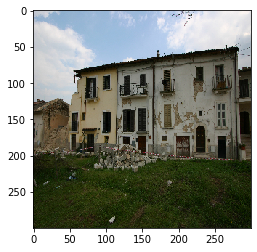

In [21]:
#Example Report
example_img = cv2.imread(train_data[7])
example_img  = cv2.resize(example_img, (300, 300), interpolation = cv2.INTER_NEAREST)
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(example_img)

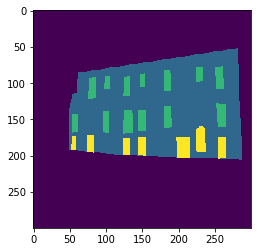

In [22]:
example_mask = cv2.imread(mask_data[7])
example_mask  = cv2.resize(example_mask, (300, 300), interpolation = cv2.INTER_NEAREST)
example_mask = cv2.cvtColor(example_mask, cv2.COLOR_BGR2GRAY)
imgplot = plt.imshow(example_mask)

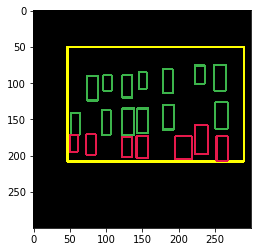

In [23]:
example_mask_ssd = cv2.imread("/data/ssd_ilija_data/ground_truth/mask_with_bboxes/gt_mask_007.png")
imgplot = plt.imshow(example_mask_ssd)